In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from country_list import countries_for_language

# Preprocessing

We should include techniques like filling in missing data (data imputation), reshaping data (data
manipulation), adjusting data ranges (scaling), converting data (encoding), and grouping
data into categories (discretizing). 

As well as methods to simplify complex data
(dimensionality reduction) and handle text data (text processing) using tools like text
vectorization and TF-IDF

### Loading the CSVs as Pandas dataframe

In [2]:
df_books = pd.read_csv('BX-Books.csv')
df_ratings = pd.read_csv('BX-Ratings.csv')
df_users = pd.read_csv('BX-Users.csv')

### Setting the index for both books and Users

In [3]:
df_books = df_books.set_index('ISBN')
df_users = df_users.set_index('User-ID')

### Resolving wrong Data

#### For users :

In [4]:
df_users.loc[df_users['User-Age'].apply(lambda s : ('.' in str(s)))]

,User-City,User-State,User-Country,User-Age
User-ID,,,,


In [5]:
def remove_non_numeric_chars(s):
    return ''.join(char for char in str(s) if char.isdigit())

In [6]:
def remove_space(s):
    if s[0] == ' ': 
        return s[1:]
    return s

In [7]:
#We remove all characters that are non-numeric from the ages , and we store them as floats
df_users['User-Age'] = df_users['User-Age'].apply(remove_non_numeric_chars)
df_users['User-Age'] = pd.to_numeric(df_users['User-Age'], errors='coerce')

In [8]:
#We remove quotes and spaces at first place
df_users['User-Country'] = df_users['User-Country'].apply(lambda country : str(country))

df_users['User-Country'] = df_users['User-Country'].str.replace('"', '', regex=True)
df_users['User-Country'] = df_users['User-Country'].apply(remove_space)

In [9]:
#We remove ages that do not make sense
lower_bound = 4
upper_bound = 110

df_users.loc[(df_users['User-Age'] < lower_bound) | (df_users['User-Age'] > upper_bound)] = np.nan

In [10]:
#We get the list of country and the list of values that are not countries
country_names = [name.lower() for _ , name in countries_for_language('en')]

country_names = country_names + ['hong kong','saint lucia', 'czech republic', 'trinidad and tobago', 'macedonia']
# they are all already in the list, macedonia as north macedonia
# usa and the latter should all go in the dictionnary

[name for name in country_names if name[0]=='n']


['namibia',
 'nauru',
 'nepal',
 'netherlands',
 'new caledonia',
 'new zealand',
 'nicaragua',
 'niger',
 'nigeria',
 'niue',
 'norfolk island',
 'north korea',
 'north macedonia',
 'northern mariana islands',
 'norway']

In [11]:
df_users.loc[~df_users['User-Country'].isin(country_names),'User-Country'].unique()

array(['usa', 'nan', 'quit', nan, 'alderney', 'csa', 'england', 'n/a',
       'u.s. of a.', 'catalunya', 'tdzimi', 'u.s.a.', 'wales', 'españa',
       'c', 'antigua and barbuda', 'ferrara', 'morgan', 'lkjlj', 'urugua',
       'n/a - on the road', 'ua', 'euskal herria', 'yugoslavia',
       'richmond country', 'framingham', 'united kindgonm', 'universe',
       'scotland', 'aroostook', 'america', 'worcester', 'van wert',
       'u.s>', 'far away...', 'k1c7b1', 'orense', 'rutherford', 'camden',
       'ysa', 'u.s.a>', 'u.a.e', 'petrolwar nation', 'us', 'shelby',
       'italia', 'catalonia', 'caribbean sea', 'cananda', 'united state',
       'pender', 'la france', 'republic of panama', 'phillipines', 'u.k.',
       'united states of america', 'los estados unidos de norte america',
       'orange co', 'unknown', 'l`italia', 'kern', 'st.thomasi',
       'everywhere and anywhere', 'united staes', 'deutschland'],
      dtype=object)

In [12]:
# Countries that are mispelled or in another language should be corrected 
corrected = {
    'usa': 'united states',
    'u.s.a.': 'united states',
    'u.s. of a.': 'united states',
    'america': 'united states', 
    'u.s>': 'united states',
    'ysa': 'united states',
    'u.s.a>': 'united states',
    'united state': 'united states',
    'us': 'united states',
    'united states of america': 'united states',
    'united states': 'united states',
    'los estados unidos de norte america': 'united states',
    'united staes': 'united states',
    'españa': 'spain',
    'italia': 'italy',
    'l`italia': 'italy',
    'urugua': 'uruguay',
    'united kindgonm': 'united kingdom',
    'burma': 'myanmar (burma)',
    'u.a.e': 'united arab emirates',
    'nz': 'new zealand',
    'cananda': 'canada',
    'la france': 'france',
    'republic of panama': 'panama',
    'phillipines': 'philippines',
    'u.k.': 'united kingdom',
    'deutschland': 'germany',
    'england': 'united kingdom',
    'wales': 'united kingdom',
    'scotland': 'united kingdom',
    'hong kong': 'hong kong sar china',
    'saint lucia': 'st. lucia',
    'czech republic':'czechia',
    'trinidad and tobago': 'trinidad & tobago',
    'macedonia': 'north macedonia'}

df_users['User-Country'] = df_users['User-Country'].apply(lambda x : (corrected[x] if x in corrected.keys() else x))


In [13]:
df_users.loc[~df_users['User-Country'].isin(country_names),'User-Country'].unique()

array(['nan', 'quit', nan, 'alderney', 'csa', 'n/a', 'catalunya',
       'tdzimi', 'c', 'antigua and barbuda', 'ferrara', 'morgan', 'lkjlj',
       'n/a - on the road', 'ua', 'euskal herria', 'yugoslavia',
       'richmond country', 'framingham', 'universe', 'aroostook',
       'worcester', 'van wert', 'far away...', 'k1c7b1', 'orense',
       'rutherford', 'camden', 'petrolwar nation', 'shelby', 'catalonia',
       'caribbean sea', 'pender', 'orange co', 'unknown', 'kern',
       'st.thomasi', 'everywhere and anywhere'], dtype=object)

In [14]:
#We set the values that are not countries to nan
df_users.loc[~df_users['User-Country'].isin(country_names),'User-Country'] = np.nan
   
df_users['User-Country'].unique()

array(['canada', 'united states', nan, 'united kingdom', 'philippines',
       'india', 'germany', 'finland', 'spain', 'italy', 'france',
       'austria', 'netherlands', 'switzerland', 'new zealand', 'malaysia',
       'australia', 'portugal', 'singapore', 'taiwan', 'south africa',
       'latvia', 'sweden', 'ireland', 'iran', 'slovenia',
       'hong kong sar china', 'israel', 'denmark', 'japan', 'romania',
       'argentina', 'mexico', 'malta', 'trinidad & tobago', 'thailand',
       'brazil', 'guatemala', 'china', 'chile', 'bermuda', 'jersey',
       'south korea', 'belgium', 'greece', 'turkey', 'moldova', 'czechia',
       'nigeria', 'tanzania', 'bahamas', 'palau', 'uruguay', 'luxembourg',
       'egypt', 'slovakia', 'iceland', 'kuwait', 'st. lucia', 'bulgaria',
       'norway', 'costa rica', 'antarctica', 'united arab emirates',
       'papua new guinea', 'colombia', 'algeria', 'grenada',
       'cayman islands', 'jamaica', 'guernsey', 'nepal', 'vietnam',
       'afghanistan', 'a

In [15]:
#If the country is missing but city is known from other data, so we can identify their country
city_list = df_users['User-City'].unique()

city_to_country_dict = {}
for i in range(len(df_users)) :
    city = df_users.iat[i,1]
    country = df_users.iat[i,3]
    if (not pd.isnull(city)) and (not pd.isnull(country)) :
        city_to_country_dict[city] = country


for i in range(len(df_users)):
    city = df_users.iat[i,1]
    country = df_users.iat[i,3]
    if pd.isnull(country) and (city in city_to_country_dict.keys()):
        print(country, i, city)
        df_users.iat[i, 3] = city_to_country_dict[city]

nan 0  ontario
nan 1  tennessee
nan 2  new mexico
nan 3  virginia
nan 5  washington
nan 6  oregon
nan 7  north carolina
nan 11  washington
nan 13  british columbia
nan 14  missouri
nan 17  california
nan 18  oregon
nan 20  pennsylvania
nan 22  alberta
nan 27  virginia
nan 32  missouri
nan 33  new york
nan 35  new york
nan 38  minnesota
nan 39  texas
nan 41  massachusetts
nan 42  quit
nan 44  washington
nan 45  colorado
nan 46  virginia
nan 47  missouri
nan 52  virginia
nan 57  california
nan 63  maryland
nan 67  washington
nan 69  dc
nan 70  west virginia
nan 71  italy
nan 72  new york
nan 74  texas
nan 76  ontario
nan 81  arkansas
nan 84  georgia
nan 87  illinois
nan 88  washington
nan 89  massachusetts
nan 92  mississippi
nan 96  berlin
nan 98  virginia
nan 99  nova scotia
nan 100  oregon
nan 102  california
nan 103  california
nan 105  tennessee
nan 106  new york
nan 110  zuid holland
nan 114  texas
nan 115  florida
nan 117  louisiana
nan 122  california
nan 123  pennsylvania
nan 12

#### For books :

In [16]:
df_books.replace('N/A',np.NaN)

,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
ISBN,,,,
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
0440234743,The Testament,John Grisham,1999,Dell
0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume
...,...,...,...,...
0375411615,"Love, Etc.",Julian Barnes,2001,Alfred A. Knopf
0836227751,The Wit And Whimsy Of Mary Engelbreit,Mary Engelbreit,1997,Andrews McMeel Publishing
8433966634,Los Detectives Salvajes,Roberto Bolano,2003,Anagrama


In [17]:
# Books titles seem to all make sense
print(df_books['Book-Title'].apply(lambda title : type(title)).unique())

small_title_line = df_books['Book-Title'].apply(lambda title : len(title)).argmin()
big_title_line = df_books['Book-Title'].apply(lambda title : len(title)).argmax()

print('Title : ', df_books.iat[small_title_line, 0], '; Author :', df_books.iat[small_title_line, 1])
print('Title : ', df_books.iat[big_title_line, 0], '; Author :', df_books.iat[big_title_line, 1])

[<class 'str'>]
Title :  Q ; Author : Luther Blissett
Title :  Baby Bargains: Secrets to Saving 20% to 50% on Baby Furniture, Equipment, Clothes, Toys, Maternity Wear and Much, Much More! (Baby Bargains: Secrets to Saving 20% to 50% on Baby Furniture, Equipment, Clothes, Toys,) ; Author : Denise Fields


In [18]:
# Books authors seem to all make sense
print(df_books['Book-Title'].apply(lambda title : type(title)).unique())

small_author_line = df_books['Book-Author'].apply(lambda title : len(title)).argmin()
big_author_line = df_books['Book-Author'].apply(lambda title : len(title)).argmax()

print('Title : ', df_books.iat[small_author_line, 0], '; Author :', df_books.iat[small_author_line, 1])
print('Title : ', df_books.iat[big_author_line, 0], '; Author :', df_books.iat[big_author_line, 1])

[<class 'str'>]
Title :  Nothing But The Truth: A Documentary Novel ; Author : Avi
Title :  The Higher Taste: A Guide to Gourmet Vegetarian Cooking and a Karma-Free Diet ; Author : A. C. Bhaktivedanta Swami Prabhupada et al.


In [19]:
# For the year of publication we remove to ancient and future years
print(df_books['Year-Of-Publication'].apply(lambda title : type(title)).unique())

lowest_year_line = df_books['Year-Of-Publication'].argmin()
highest_year_line = df_books['Year-Of-Publication'].argmax()

print('Year : ', df_books.iat[lowest_year_line, 2], 'Title : ', df_books.iat[lowest_year_line, 0])
print('Year : ', df_books.iat[highest_year_line, 2], 'Title : ', df_books.iat[highest_year_line, 0])

# Apart from books published in 0, then books are all published later than 1920
not_ancient = df_books[df_books['Year-Of-Publication'] > 0]
print('Lowest year (except 0) :', not_ancient['Year-Of-Publication'].min())

[<class 'int'>]
Year :  0 Title :  Poisonwood Bible Edition Uk
Year :  2030 Title :  MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS)
Lowest year (except 0) : 1920


In [20]:
# We put NaNs for years that don't make sense
df_books.loc[df_books['Year-Of-Publication'] < 1900 , 'Year-Of-Publication'] = np.nan
df_books.loc[df_books['Year-Of-Publication'] > 2024 , 'Year-Of-Publication'] = np.nan

print(df_books['Year-Of-Publication'].min())
print(df_books['Year-Of-Publication'].max())

1920.0
2005.0


In [21]:
# Books publishers seem to all make sense
print(df_books['Book-Publisher'].apply(lambda title : type(title)).unique())

longest_publi_line = df_books['Book-Publisher'].apply(lambda publisher: len(publisher)).argmax()
shortest_publi_line = df_books['Book-Publisher'].apply(lambda publisher: len(publisher)).argmin()

print('Publisher : ', df_books.iat[longest_publi_line, 3], 'Title : ', df_books.iat[longest_publi_line, 0])
print('Publisher : ', df_books.iat[shortest_publi_line, 3], 'Title : ', df_books.iat[shortest_publi_line, 0])

[<class 'str'>]
Publisher :  Ullstein-Taschenbuch-Verlag, Zweigniederlassung der Ullstein Buchverlage GmbH Title :  Die Welle
Publisher :  LP Title :  Therese Raquin


#### For Ratings (no changes)

In [22]:
# the ratings seem all correct
df_ratings[(df_ratings['Book-Rating'] > 10) & (df_ratings['Book-Rating'] < 0)]

,User-ID,ISBN,Book-Rating


In [23]:
# are all the ISBN's in df_books
print(df_ratings['ISBN'].apply(lambda isbn: isbn in df_books.index).all())

# are all User-ID in df_users
print(df_ratings['User-ID'].apply(lambda isbn: isbn in df_users.index).all())

True
True


### Joining the dataframes

In [24]:
df_users_ratings = df_ratings.join(df_users, on='User-ID', how='inner')
df_users_ratings

,User-ID,ISBN,Book-Rating,User-City,User-State,User-Country,User-Age
0,276744,038550120X,7,torrance,california,united states,28.0
1,276754,0684867621,8,alberta beach,alberta,canada,19.0
2,276755,0451166892,5,frankfurt am main,hessen,germany,32.0
3,276762,0380711524,5,duisburg,nordrhein-westfalen,germany,25.0
4,276772,0553572369,7,bonn,nordrhein-westfalen,germany,21.0
...,...,...,...,...,...,...,...
204159,276688,0892966548,10,fort lee,new jersey,united states,41.0
204160,276688,1551669315,6,fort lee,new jersey,united states,41.0
204161,276704,0345386108,6,cedar park,texas,united states,33.0
204162,276704,0743211383,7,cedar park,texas,united states,33.0


In [25]:
df_books_ratings = df_ratings.join(df_books, on='ISBN', how='inner')
df_books_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday
1,276754,0684867621,8,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999.0,Scribner
2,276755,0451166892,5,The Pillars of the Earth,Ken Follett,1996.0,Signet Book
3,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon
4,276772,0553572369,7,Pay Dirt (Mrs. Murphy Mysteries (Paperback)),RITA MAE BROWN,1996.0,Bantam
...,...,...,...,...,...,...,...
204159,276688,0892966548,10,Killer Market: A Deborah Knott Mystery (Debora...,Margaret Maron,1997.0,Warner Books Inc
204160,276688,1551669315,6,The Third Wife,Jasmine Cresswell,2002.0,Mira
204161,276704,0345386108,6,Winter Moon,Dean R. Koontz,1995.0,Ballantine Books
204162,276704,0743211383,7,Dreamcatcher,Stephen King,2001.0,Scribner


In [26]:
df_all = df_books_ratings.join(df_users, on='User-ID', how='inner')
df_all

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,User-City,User-State,User-Country,User-Age
0,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,torrance,california,united states,28.0
1,276754,0684867621,8,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999.0,Scribner,alberta beach,alberta,canada,19.0
2,276755,0451166892,5,The Pillars of the Earth,Ken Follett,1996.0,Signet Book,frankfurt am main,hessen,germany,32.0
3,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon,duisburg,nordrhein-westfalen,germany,25.0
4,276772,0553572369,7,Pay Dirt (Mrs. Murphy Mysteries (Paperback)),RITA MAE BROWN,1996.0,Bantam,bonn,nordrhein-westfalen,germany,21.0
...,...,...,...,...,...,...,...,...,...,...,...
204159,276688,0892966548,10,Killer Market: A Deborah Knott Mystery (Debora...,Margaret Maron,1997.0,Warner Books Inc,fort lee,new jersey,united states,41.0
204160,276688,1551669315,6,The Third Wife,Jasmine Cresswell,2002.0,Mira,fort lee,new jersey,united states,41.0
204161,276704,0345386108,6,Winter Moon,Dean R. Koontz,1995.0,Ballantine Books,cedar park,texas,united states,33.0
204162,276704,0743211383,7,Dreamcatcher,Stephen King,2001.0,Scribner,cedar park,texas,united states,33.0


# Firsts Plots

#### Plots of Average Rating vs Number of Books read

We count the number of ratings and average rating for each user

In [27]:
df_users['Num-Book-Rated'] = df_users_ratings[['User-ID','ISBN']].groupby('User-ID').count()
df_users['Avg-Rating'] = df_users_ratings[['User-ID','Book-Rating']].groupby('User-ID').mean()
df_users

,User-City,User-State,User-Country,User-Age,Num-Book-Rated,Avg-Rating
User-ID,,,,,,
8,timmins,ontario,canada,23.0,1,5.00
9,germantown,tennessee,united states,57.0,1,6.00
16,albuquerque,new mexico,united states,33.0,1,9.00
17,chesapeake,virginia,united states,27.0,4,5.25
19,weston,,NaN,14.0,1,7.00
...,...,...,...,...,...,...
278846,toronto,ontario,canada,23.0,1,8.00
278849,georgetown,ontario,canada,23.0,1,9.00
278851,dallas,texas,united states,33.0,4,5.75


48299 vs 48295


Text(0.5, 1.0, 'Scatter plot of the mean rating versus the number of ratings, for each users')

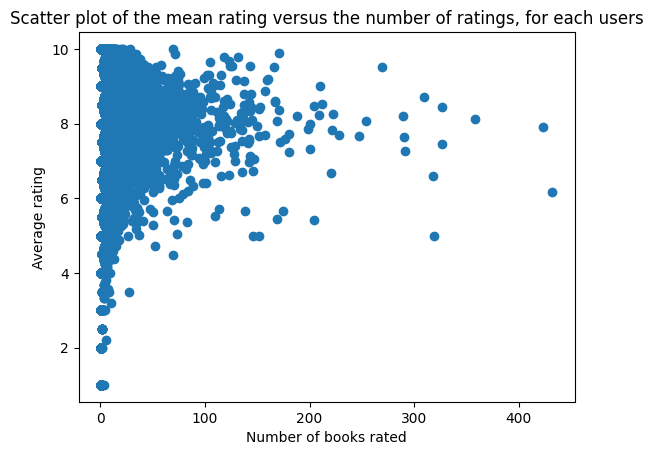

In [28]:
df_users_plot = df_users[df_users['Num-Book-Rated'] < 500]
print(f'{len(df_users)} vs {len(df_users_plot)}')

plt.scatter(df_users_plot['Num-Book-Rated'], df_users_plot['Avg-Rating'])
plt.xlabel('Number of books rated')
plt.ylabel('Average rating')
plt.title('Scatter plot of the mean rating versus the number of ratings, for each users')

In [29]:
print('Youngest rater\'s age :' ,df_users['User-Age'].min())
print('Oldest rater\'s age :', df_users['User-Age'].max())

Youngest rater's age : 4.0
Oldest rater's age : 108.0


In [30]:
df_users

,User-City,User-State,User-Country,User-Age,Num-Book-Rated,Avg-Rating
User-ID,,,,,,
8,timmins,ontario,canada,23.0,1,5.00
9,germantown,tennessee,united states,57.0,1,6.00
16,albuquerque,new mexico,united states,33.0,1,9.00
17,chesapeake,virginia,united states,27.0,4,5.25
19,weston,,NaN,14.0,1,7.00
...,...,...,...,...,...,...
278846,toronto,ontario,canada,23.0,1,8.00
278849,georgetown,ontario,canada,23.0,1,9.00
278851,dallas,texas,united states,33.0,4,5.75


[(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70)]
50
4438
14011
13308
7583
5375
2596


Text(0.5, 1.0, 'Average rating given against ')

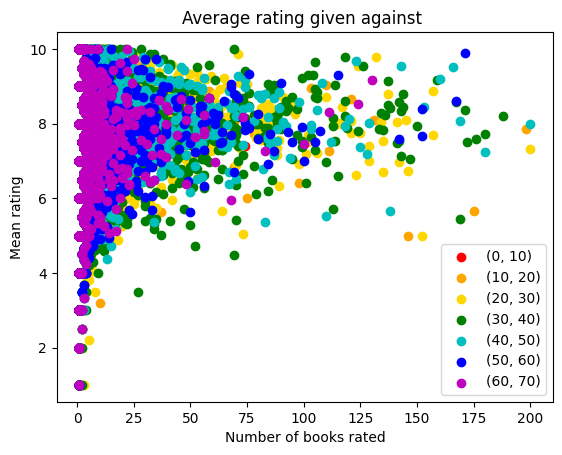

In [31]:
# We plot nb books rated against mean rating for every age group
colours = ['r','orange','gold','g','c','b','m']   # to have clearly distinct colours
age_groups = [(10*i,10*i+10) for i in range(7)] # to have them in order in the legend instead of the order given by the groupby()
print(age_groups)

max_book_read = 200

fig, ax = plt.subplots()

for i in range(7):
    df_age_group = df_users[(df_users['User-Age'] >= age_groups[i][0])
                            & (df_users['User-Age'] < age_groups[i][1])
                            & (df_users['Num-Book-Rated'] <= max_book_read)]
    print(df_age_group.shape[0])
    ax.scatter(df_age_group['Num-Book-Rated'], df_age_group['Avg-Rating'], c=colours[i], label=str(age_groups[i])) 

ax.legend()
plt.xlabel('Number of books rated')
plt.ylabel('Mean rating')
plt.title('Average rating given against ')


In [32]:
nb_users_per_country = df_users[['User-Country', 'Avg-Rating']].groupby('User-Country').count()\
                                                               .reset_index().rename(columns={'Avg-Rating':'Count'})
main_countries = list(nb_users_per_country.sort_values(by='Count', ascending=False).head(10)['User-Country'])
main_countries

['united states',
 'canada',
 'germany',
 'united kingdom',
 'australia',
 'spain',
 'italy',
 'france',
 'netherlands',
 'new zealand']

34356
4596
1857
1776
977


Text(0.5, 1.0, '')

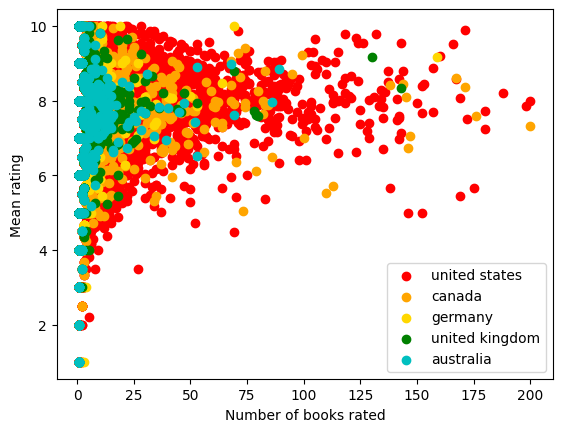

In [33]:
# We plot nb books rated against mean rating for every main countries
colours = ['r','orange','gold','g','c','b','m']   # to have clearly distinct colours

max_book_read = 200

fig, ax = plt.subplots()

for i in range(5):
    df_country_group = df_users[(df_users['User-Country'] == main_countries[i])
                                & (df_users['Num-Book-Rated'] <= max_book_read)]
    print(df_country_group.shape[0])
    ax.scatter(df_country_group['Num-Book-Rated'], df_country_group['Avg-Rating'], c=colours[i], label=main_countries[i]) 

ax.legend()
plt.xlabel('Number of books rated')
plt.ylabel('Mean rating')
plt.title('')

The lasts graphs are not conclusive so we decided to change our question

#### Plots of Rating against age

We count the number of reviews for each author

In [34]:
df_authors = df_all[['Book-Author','Book-Rating']].groupby('Book-Author').count() \
                                                  .rename(columns={'Book-Rating': 'Num-Rating'})
df_authors['Avg-Rating'] = df_all[['Book-Author','Book-Rating']].groupby('Book-Author').mean()
df_authors['Avg-Age-Reader'] = df_all[['Book-Author','User-Age']].groupby('Book-Author').mean()
df_authors['Avg-Publish-Date'] = df_books[['Book-Author','Year-Of-Publication']].groupby('Book-Author').mean()
df_authors = df_authors.dropna()
df_authors

,Num-Rating,Avg-Rating,Avg-Age-Reader,Avg-Publish-Date
Book-Author,,,,
A. A. Attanasio,4,7.250000,27.750000,1997.0
A. A. Milne,22,8.045455,36.090909,1992.0
A. C. Bhaktivedanta Swami Prabhupada et al.,9,7.777778,35.444444,1991.0
A. C. Crispin,4,6.500000,37.750000,1984.0
A. C. Doyle,9,8.555556,31.111111,1998.0
...,...,...,...,...
Zz Packer,4,8.250000,51.500000,2004.0
"\Pickles\""""",4,8.500000,39.000000,1995.0
bell hooks,5,9.000000,32.200000,2001.0


In [35]:
df_authors.sort_values(by='Num-Rating', ascending=False).head(10)

,Num-Rating,Avg-Rating,Avg-Age-Reader,Avg-Publish-Date
Book-Author,,,,
Stephen King,4192,7.873569,34.189345,1993.773684
Nora Roberts,2667,7.629546,36.471834,2000.048780
John Grisham,2389,7.521557,37.851261,1997.750000
James Patterson,2237,7.709879,39.237753,1999.444444
J. K. Rowling,1644,8.984185,31.911097,2000.160000
Mary Higgins Clark,1465,7.570648,38.269416,1995.838710
Janet Evanovich,1409,7.952449,38.788833,2000.333333
Dean R. Koontz,1393,7.552764,37.243146,1995.589286
Sue Grafton,1159,7.742882,39.281763,1994.322581


In [36]:
main_authors = list(df_authors.sort_values(by='Num-Rating', ascending=False).index)
main_authors

['Stephen King',
 'Nora Roberts',
 'John Grisham',
 'James Patterson',
 'J. K. Rowling',
 'Mary Higgins Clark',
 'Janet Evanovich',
 'Dean R. Koontz',
 'Sue Grafton',
 'Anne Rice',
 'Tom Clancy',
 'Nicholas Sparks',
 'Dan Brown',
 'JOHN GRISHAM',
 'Michael Crichton',
 'Danielle Steel',
 'Barbara Kingsolver',
 'Anita Shreve',
 'Patricia Daniels Cornwell',
 'Alice Sebold',
 'V.C. Andrews',
 'Maeve Binchy',
 'Sandra Brown',
 'Rebecca Wells',
 'Anne McCaffrey',
 'Neil Gaiman',
 'Jack Canfield',
 'John Sandford',
 'Lilian Jackson Braun',
 'Amy Tan',
 'Helen Fielding',
 'Robin Cook',
 'John Irving',
 'Douglas Adams',
 'Wally Lamb',
 'Orson Scott Card',
 'Catherine Coulter',
 'Terry Pratchett',
 'Jude Deveraux',
 'Piers Anthony',
 'Rich Shapero',
 'Jonathan Kellerman',
 'Ken Follett',
 'Margaret Atwood',
 'Nick Hornby',
 'MICHAEL CRICHTON',
 'Frank McCourt',
 'Thomas Harris',
 'Johanna Lindsey',
 'David Baldacci',
 'Jane Austen',
 'Tracy Chevalier',
 'Michael Connelly',
 'J.R.R. TOLKIEN',
 'L

4192
2667
2389
2237
1644


Text(0.5, 1.0, '')

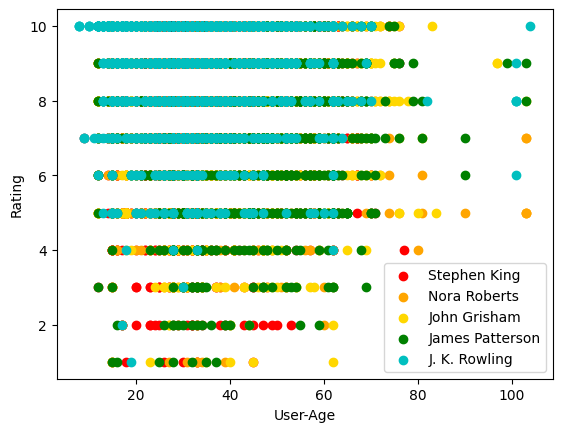

In [37]:
# We plot nb books rated against mean rating for every main countries
colours = ['r','orange','gold','g','c','b','m']   # to have clearly distinct colours

fig, ax = plt.subplots()


for i in range(5):
    df_author_group = df_all[(df_all['Book-Author'] == main_authors[i])]
    print(df_author_group.shape[0])
    ax.scatter(df_author_group['User-Age'], df_author_group['Book-Rating'], c=colours[i], label=main_authors[i]) 

ax.legend()
plt.xlabel('User-Age')
plt.ylabel('Rating')
plt.title('')

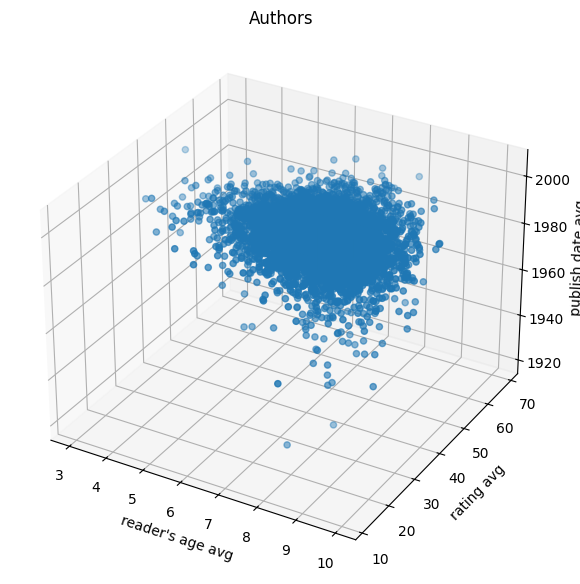

In [38]:
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection="3d")
ax.scatter(df_authors['Avg-Rating'], 
            df_authors['Avg-Age-Reader'], 
            df_authors['Avg-Publish-Date'])

ax.set_ylabel('rating avg')
ax.set_xlabel('reader\'s age avg')
ax.set_zlabel('publish date avg')
ax.set_title('Authors')

plt.show()

4192
2667
2389
2237
1644


Text(0.5, 1.0, '')

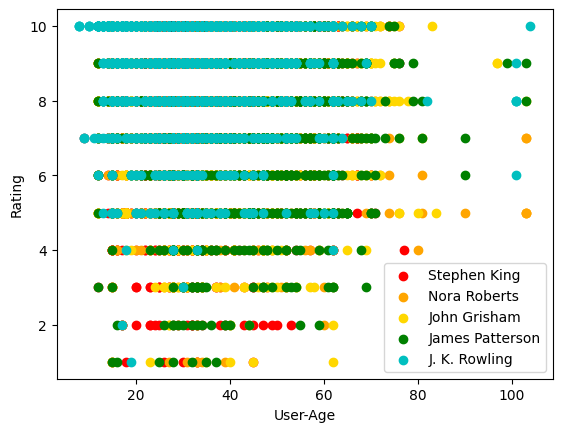

In [39]:
# We plot nb books rated against mean rating for every main countries
colours = ['r','orange','gold','g','c','b','m']   # to have clearly distinct colours

fig, ax = plt.subplots()


for i in range(5):
    df_author_group = df_all[(df_all['Book-Author'] == main_authors[i])]
    print(df_author_group.shape[0])
    ax.scatter(df_author_group['User-Age'], df_author_group['Book-Rating'], c=colours[i], label=main_authors[i]) 

ax.legend()
plt.xlabel('User-Age')
plt.ylabel('Rating')
plt.title('')

# K neighbours (for the old question)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [75]:
age_groups = [(10*i,10*i+10) for i in range(7)]
print(age_groups)

def which_age_group(age):
    for i in range(7):
        if ((age >= age_groups[i][0]) & (age < age_groups[i][1])) :
            return str(age_groups[i])
    return np.nan

df_users['Age-Group'] = df_users['User-Age'].apply(which_age_group)
df_users

[(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70)]


,User-City,User-State,User-Country,User-Age,Num-Book-Rated,Avg-Rating,Age-Group,Rating-Group,Num-book-rated-Group
User-ID,,,,,,,,,
8,timmins,ontario,canada,23.0,1,5.00,"(20, 30)","(4, 5)","(0, 1000)"
9,germantown,tennessee,united states,57.0,1,6.00,"(50, 60)","(5, 6)","(0, 1000)"
16,albuquerque,new mexico,united states,33.0,1,9.00,"(30, 40)","(8, 9)","(0, 1000)"
17,chesapeake,virginia,united states,27.0,4,5.25,"(20, 30)","(5, 6)","(0, 1000)"
19,weston,,NaN,14.0,1,7.00,"(10, 20)","(6, 7)","(0, 1000)"
...,...,...,...,...,...,...,...,...,...
278846,toronto,ontario,canada,23.0,1,8.00,"(20, 30)","(7, 8)","(0, 1000)"
278849,georgetown,ontario,canada,23.0,1,9.00,"(20, 30)","(8, 9)","(0, 1000)"
278851,dallas,texas,united states,33.0,4,5.75,"(30, 40)","(5, 6)","(0, 1000)"


In [76]:
Y_Column = 'Age-Group'
X_Columns = ['Num-Book-Rated', 'Avg-Rating'] # Num country as it is not numerical 


# Set random seed for reproducibility (optional)
seed = 72  # Example seed value
max_age = 70
df_users_used = df_users.loc[df_users['User-Age'] < max_age]
df_users_used = df_users_used.sample(frac=1, random_state=seed)  

# Split into 80% and 20% portions
train_size = int(0.8 * len(df_users))
train_df = df_users_used[:train_size]
test_df = df_users_used[train_size:]


X_train = train_df[X_Columns]
#print(X_train)
Y_train = train_df[Y_Column]
#print(Y_train)
X_test = test_df[X_Columns]
Y_test = test_df[Y_Column]

# k=3
knn = KNeighborsClassifier(n_neighbors=5)


# Fit to the train dataset
knn.fit(X_train, Y_train)

y_pred = knn.predict(X_test)

accuracy = knn.score(X_test, Y_test)

print('Accuracy', accuracy)

Accuracy 0.24174191336152703


In [77]:
# Function to create rating groups
rating_group = [(1*i,1*i+1) for i in range(10)]

def which_rating_group(rate):
    for i in range(10):
        if ((rate > rating_group[i][0]) & (rate <= rating_group[i][1])) :
            return str(rating_group[i])
    return np.nan

df_users['Rating-Group'] = df_users['Avg-Rating'].apply(which_rating_group)

In [78]:
# Function to create num of book rated groups
num_book_rated_group = [(1000*i,1000*i+1000) for i in range(5)]

def which_num_book_rated_group(num_book):
    for i in range(5):
        if ((num_book > num_book_rated_group[i][0]) & (num_book <= num_book_rated_group[i][1])) :
            return str(num_book_rated_group[i])
    return np.nan

df_users['Num-book-rated-Group'] = df_users['Num-Book-Rated'].apply(which_num_book_rated_group)

In [80]:
# Getting the Mutual Information for the train data sets
from sklearn.metrics import normalized_mutual_info_score

MI_rating_and_age_group = normalized_mutual_info_score(Y_train, 
                                                        train_df['Rating-Group'], 
                                                        average_method='min')
MI_book_rated_and_age_group = normalized_mutual_info_score(Y_train, 
                                                        train_df['Num-book-rated-Group'], 
                                                        average_method='min')

print("MI rating and age group = ", MI_rating_and_age_group)
print("MI num of book rated and age group = ", MI_book_rated_and_age_group)

MI rating and age group =  0.001356326710070198
MI num of book rated and age group =  0.17339586570952897


# K means

In [91]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

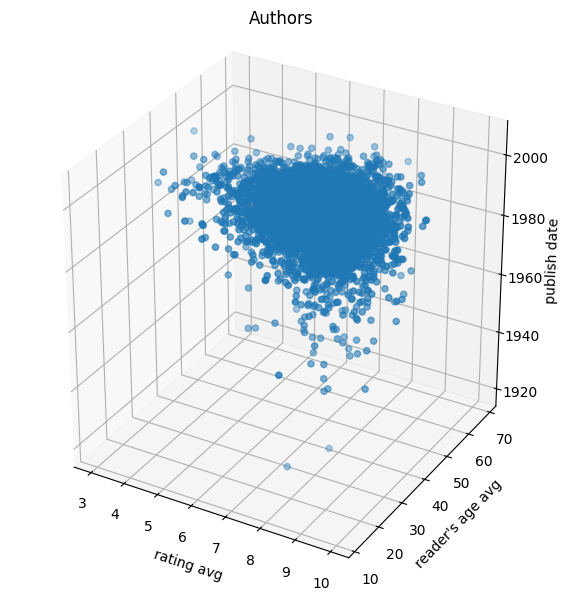

In [44]:
fig = plt.figure(figsize=(7, 10))
ax = plt.axes(projection="3d")
ax.scatter(df_authors['Avg-Rating'], 
            df_authors['Avg-Age-Reader'], 
            df_authors['Avg-Publish-Date'])

ax.set_box_aspect((1, 1, 1.05))
ax.set_xlabel('rating avg')
ax.set_ylabel('reader\'s age avg')
ax.set_zlabel('publish date')
ax.set_title('Authors')

plt.show()

In [45]:
def plot_kmeans(df, clusters):
    """
    generate a 3d plot given sklearn's kmeans implementation 
    """
    colormap = {0: 'red', 1: 'green', 2: 'blue', 3 : 'yellow', 4 : 'magenta', 5 : 'cyan'}
    
    fig = plt.figure(figsize=(7, 10))
    ax = plt.axes(projection="3d")
    ax.scatter(df['Avg-Age-Reader'], 
               df['Avg-Publish-Date'],
               df['Avg-Rating'], 
               c=[colormap.get(x) for x in clusters.labels_])
    
    ax.set_xlabel('Avg-Age-Reader')
    ax.set_ylabel('Avg-Publish-Date')
    ax.set_zlabel('Avg-Rating')
    ax.set_title(f"k = {len(set(clusters.labels_))}")

    plt.show()

In [46]:
# Removing all NaN in data and taking only the needed columns
df_clust = df_authors[['Avg-Rating','Avg-Age-Reader','Avg-Publish-Date']].dropna()
df_clust

,Avg-Rating,Avg-Age-Reader,Avg-Publish-Date
Book-Author,,,
A. A. Attanasio,7.250000,27.750000,1997.0
A. A. Milne,8.045455,36.090909,1992.0
A. C. Bhaktivedanta Swami Prabhupada et al.,7.777778,35.444444,1991.0
A. C. Crispin,6.500000,37.750000,1984.0
A. C. Doyle,8.555556,31.111111,1998.0
...,...,...,...
Zz Packer,8.250000,51.500000,2004.0
"\Pickles\""""",8.500000,39.000000,1995.0
bell hooks,9.000000,32.200000,2001.0


In [47]:
normalized_data = MinMaxScaler().fit_transform(df_clust)
normalized_data = pd.DataFrame(normalized_data, columns=df_clust.columns)

#### Elbow Method

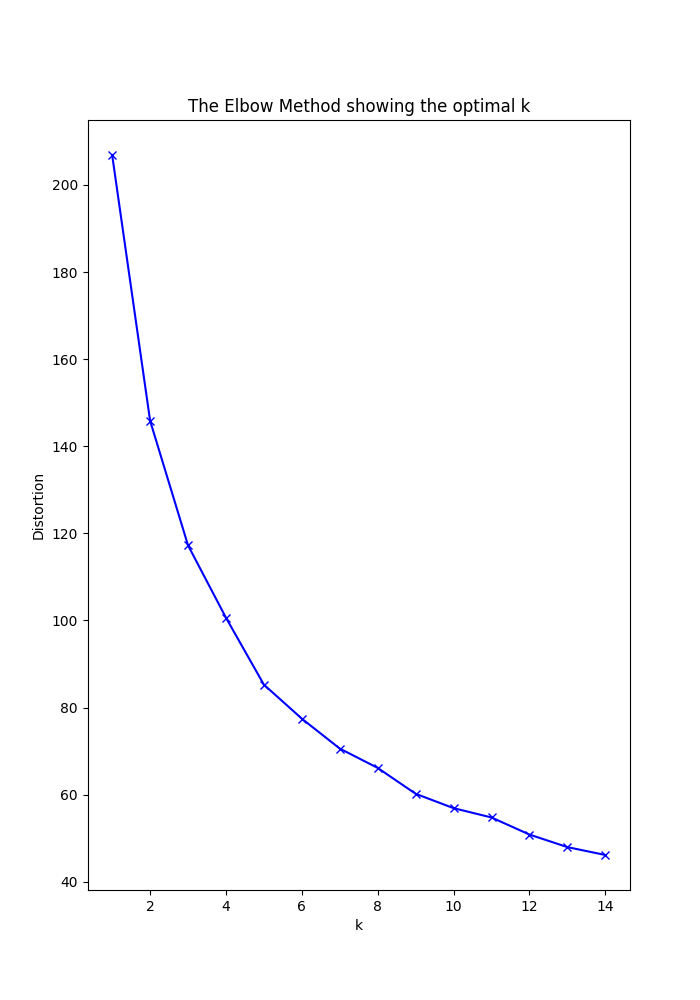

In [83]:
distortions = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_data)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(7, 10))
ax = plt.axes()
ax.plot(k_range, distortions, 'bx-')

ax.set_title('The Elbow Method showing the optimal k')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')

plt.show()

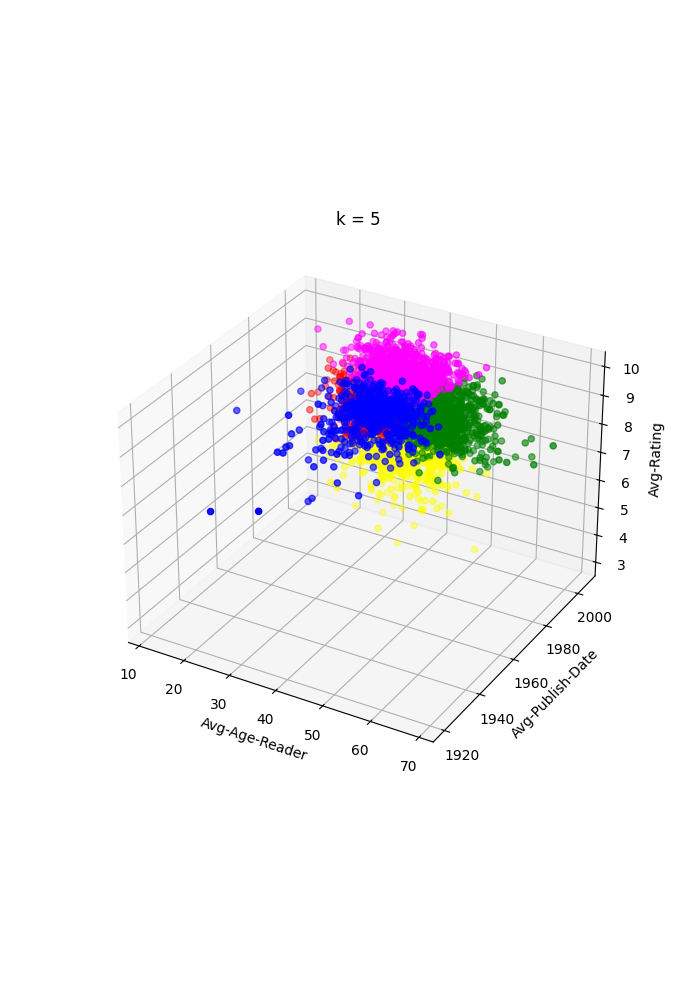

In [86]:
%matplotlib widget
clusters = KMeans(n_clusters=5).fit(normalized_data)
plot_kmeans(df_clust, clusters)

In [87]:
clusters.inertia_

85.25707119820329

# Linear Regression

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### For the old research question

In [51]:
df_lin = df_users[df_users['Num-Book-Rated'] < 500]

In [52]:
df_country_group['Num-Book-Rated'], df_country_group['Avg-Rating']

(User-ID
 1133       1
 1424      34
 1486       1
 1996       2
 2199       1
           ..
 277992     1
 278218     4
 278398     1
 278539     1
 278852     1
 Name: Num-Book-Rated, Length: 977, dtype: int64,
 User-ID
 1133      8.000000
 1424      7.058824
 1486      5.000000
 1996      7.500000
 2199      9.000000
             ...   
 277992    9.000000
 278218    8.000000
 278398    8.000000
 278539    9.000000
 278852    8.000000
 Name: Avg-Rating, Length: 977, dtype: float64)

Mean Squared Error: 2.5105318070291123
48295
48295


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


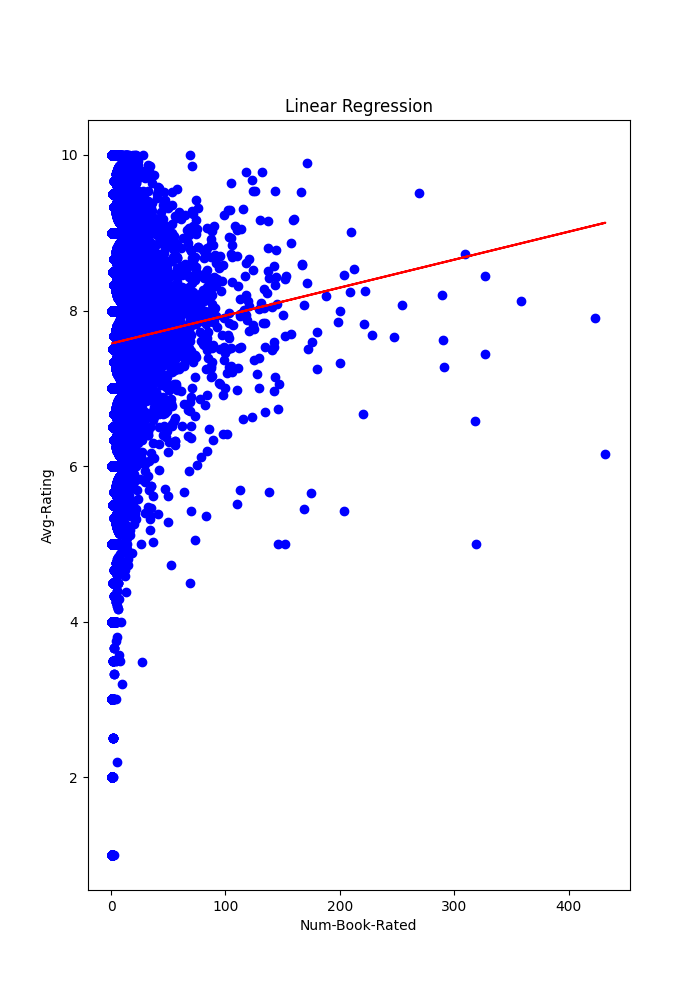

In [66]:
model = LinearRegression()
model.fit(np.array(df_lin['Num-Book-Rated']).reshape(-1,1), df_lin['Avg-Rating'])

# Make predictions
y_pred = model.predict(np.array(df_lin['Num-Book-Rated']).reshape(-1,1))

# Calculate Mean Squared Error
mse = mean_squared_error(df_lin['Avg-Rating'], y_pred)
print("Mean Squared Error:", mse)

print(len(df_lin['Num-Book-Rated']))
print(len(df_lin['Avg-Rating']))

# Plot the data and the regression line
fig = plt.figure(figsize=(7, 10))
ax = plt.axes()
ax.scatter(df_lin['Num-Book-Rated'], df_lin['Avg-Rating'], color='blue')
ax.plot(df_lin['Num-Book-Rated'], model.predict(df_lin[['Num-Book-Rated']]), color='red')
plt.xlabel('Num-Book-Rated')
plt.ylabel('Avg-Rating')
plt.title('Linear Regression')
plt.show()

In [67]:
intercept = model.intercept_
coefficients = model.coef_


correlation = df_lin[['Num-Book-Rated', 'Avg-Rating']].corr(method='pearson')

print("Intercept:", intercept)
print(f'Coefficients: {coefficients}')
print(f'Correlation: {correlation}')

Intercept: 7.575972416697003
Coefficients: [0.00359556]
Correlation:                 Num-Book-Rated  Avg-Rating
Num-Book-Rated          1.0000      0.0269
Avg-Rating              0.0269      1.0000


Mean Squared Error: 49.278634414685754


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


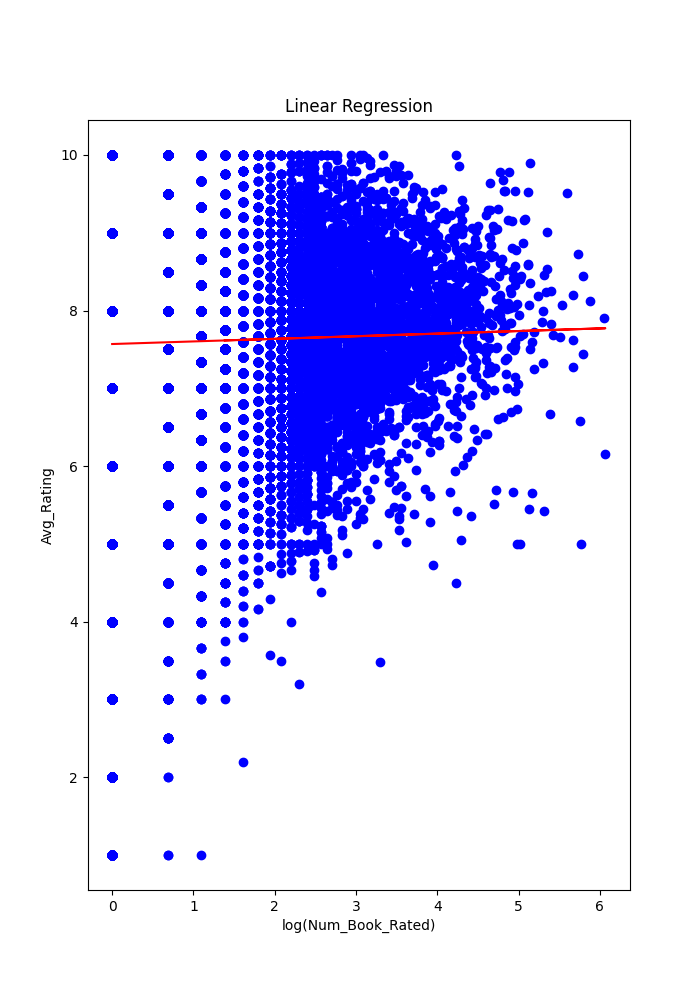

In [59]:
df_lin.loc[:,'log'] = np.log(df_lin.loc[:,'Num-Book-Rated'])

model = LinearRegression()
model.fit(np.array(df_lin['log']).reshape(-1,1), df_lin['Avg-Rating'])

# Make predictions
y_pred = model.predict(np.array(df_lin['log']).reshape(-1,1))

# Calculate Mean Squared Error
mse = mean_squared_error(df_lin['log'], y_pred)
print("Mean Squared Error:", mse)

# Plot the data and the regression line
fig = plt.figure(figsize=(7, 10))
ax = plt.axes()
ax.scatter(df_lin['log'], df_lin['Avg-Rating'], color='blue')
ax.plot(df_lin['log'], model.predict(df_lin[['log']]), color='red')
plt.xlabel('log(Num_Book_Rated)')
plt.ylabel('Avg_Rating')
plt.title('Linear Regression')
plt.show()

In [68]:
intercept = model.intercept_
coefficients = model.coef_


correlation = df_lin[['log', 'Avg-Rating']].corr(method='pearson')

print("Intercept:", intercept)
print(f'Coefficients: {coefficients}')
print(f'Correlation: {correlation}')

Intercept: 7.575972416697003
Coefficients: [0.00359556]
Correlation:                  log  Avg-Rating
log         1.000000    0.020171
Avg-Rating  0.020171    1.000000


### For the new research question

In [57]:
from mpl_toolkits.mplot3d import Axes3D

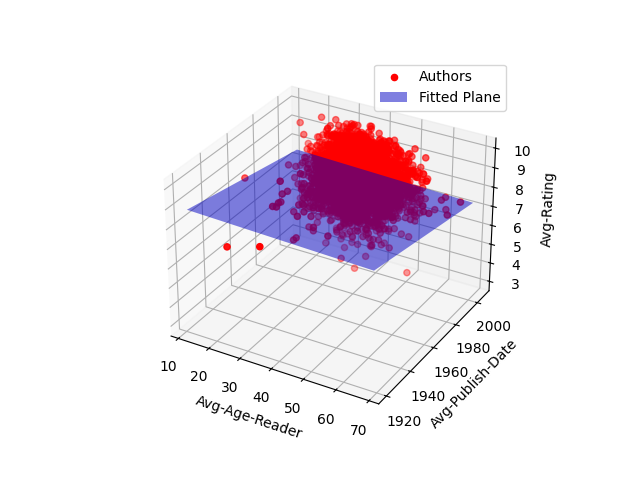

In [61]:
%matplotlib widget
model = LinearRegression()
model.fit(np.array([df_authors['Avg-Age-Reader'], df_authors['Avg-Publish-Date']]).T, 
          df_authors['Avg-Rating'])

x_range = np.linspace(df_authors['Avg-Age-Reader'].min(), df_authors['Avg-Age-Reader'].max(), 10)
y_range = np.linspace(df_authors['Avg-Publish-Date'].min(), df_authors['Avg-Publish-Date'].max(), 10)
X_plot, Y_plot = np.meshgrid(x_range, y_range)

Z_plot = model.predict(np.array([X_plot.flatten(), Y_plot.flatten()]).T).reshape(X_plot.shape)

# Plotting 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_authors['Avg-Age-Reader'], df_authors['Avg-Publish-Date'], 
           df_authors['Avg-Rating'], c='r', marker='o', label='Authors')

# Plotting the fitted plane
ax.plot_surface(X_plot, Y_plot, Z_plot, alpha=0.5, rstride=100, cstride=100, color='b', label='Fitted Plane')

ax.set_xlabel('Avg-Age-Reader')
ax.set_ylabel('Avg-Publish-Date')
ax.set_zlabel('Avg-Rating')
ax.legend()

plt.show()

In [70]:
intercept = model.intercept_
coefficients = model.coef_


correlation = df_authors[['Avg-Age-Reader', 'Avg-Publish-Date','Avg-Rating']].corr(method='pearson')

print("Intercept:", intercept)
print(f'Coefficients: {coefficients}')
print(f'Correlation: {correlation}')

Intercept: 7.575972416697003
Coefficients: [0.00359556]
Correlation:                   Avg-Age-Reader  Avg-Publish-Date  Avg-Rating
Avg-Age-Reader          1.000000          0.087428   -0.044150
Avg-Publish-Date        0.087428          1.000000   -0.117054
Avg-Rating             -0.044150         -0.117054    1.000000
